# Machine learning approach

Ways to frame problem:

- Recover colourmap from pseudocolour, then lookup data from code book.
- Recover data from pseudocolour directly. 

## Make data

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

In [123]:
def kernel(sizex, sizey):
    x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
    g = np.exp(-0.333*(x**2/float(sizex)+y**2/float(sizey)))
    return g / g.sum()

In [449]:
def gen_data(n, nx=100, ny=100, kernel_size=None, seed=None):

    imgs = []
    for i in range(n):
        rng = np.random.RandomState(seed=seed)
        z = rng.rand(nx, ny)
        kernel_size = kernel_size or (30, 30)
        f = kernel(*kernel_size)

        z = scipy.signal.convolve(z, f, mode='valid')
        z = (z - z.min())/(z.max() - z.min())
        imgs.append(z)
    
    return np.stack(imgs)

In [455]:
data = gen_data(20, kernel_size=(29,29))

In [456]:
data.shape

(20, 42, 42)

## Make `X` and `y`

In [281]:
CMAPS = {'Perceptually Uniform Sequential':
                            ['viridis', 'inferno', 'plasma', 'magma'],
         'Sequential':     ['Blues', 'BuGn', 'BuPu',
                             'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
                             'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
                             'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd',],
         'Sequential2':     ['afmhot', 'autumn', 'bone', 'cool',
                             'copper', 'gist_heat', 'gray', 'hot',
                             'pink', 'spring', 'summer', 'winter'],
         'Diverging':      ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr',
                             'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral',
                             'seismic'],
         'Qualitative':    ['Accent', 'Dark2', 'Paired', 'Pastel1',
                             'Pastel2', 'Set1', 'Set2', 'Set3'],
         'Miscellaneous':  ['gist_earth', 'terrain', 'ocean', 'gist_stern',
                             'brg', 'CMRmap', 'cubehelix',
                             'gnuplot', 'gnuplot2', 'gist_ncar',
                             'nipy_spectral', 'jet', 'rainbow',
                             'gist_rainbow', 'hsv', 'flag', 'prism'],
        }

In [282]:
import os
import logging
from matplotlib import cm
from functools import reduce

logging.basicConfig(level='INFO')

def save_image_files(y, path:str) -> None:
    """
    Make and save an image (via a matplotlib figure)
    for every image (first dimension slice) of y.
    
    Produces numbered PNG files in the path specified.
    
    Returns:
        None. Saves files as side-effect.
    """
    for i, img in enumerate(y):
        fig = plt.figure(frameon=False)
        fig.set_size_inches(5,5)

        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)

        # Note: interpolation introduces new colours.
        plt.imshow(img, cmap="jet", aspect='auto', interpolation="bicubic")
        
        if path is None:
            path = "."
        fname = os.path.join(path, f'img_{i:03d}.png')
        fig.savefig(fname, dpi=100)
        plt.close()
        logging.info(f"Saved {fname}")
    return

def make_pseudo(data, cmap:str='viridis', steps:int=128):
    cmap = cm.get_cmap(cmap)
    colours = cmap(np.linspace(0, 1, steps))[..., :3]
    pseudocolour = cmap(data)[..., :3]
    return pseudocolour, colours

def make_X_and_y(data,
                 cmap_group:str='Perceptually Uniform Sequential',
                 cmap_except:str='Qualitative',
                 steps:int=128) -> tuple:
    """
    Make a 3-channel pseudo-colour array for each
    slice in y, using the specified colourmap.
    
    Args:
        data (ndarray): M x H x W array for M examples.
        cmap_group (str): Which group of cmaps to use. (Or
            can be a single cmap.)
        steps (int): The number of steps.
    
    Returns:
        tuple: Two ndarrays, the pseudocolour images,
            and the code book.
    """
    if cmap_group.lower() == 'all':
        cmaps = reduce(lambda x, y: x + y, CMAPS.values())
    else:
        cmaps = CMAPS.get(cmap_group)
        
    cmaps = [c for c in cmaps if c not in CMAPS.get(cmap_except)]
    
    pseudos, colours = [], []
    for d in data:
        try:
            cmap = np.random.choice(cmaps)
        except:
            cmap = cmap_group
        cmap = cm.get_cmap(cmap)
    
        p, c = make_pseudo(d, cmap, steps)
        
        pseudos.append(p)
        colours.append(c)
        
    return np.stack(pseudos), np.stack(colours)

In [283]:
def display_slices(data):
    fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(12,4))
    print(axs.shape)
    for ax, d in zip(axs.flatten(), data):
        ax.imshow(d, aspect='auto')
        ax.axis('off')
    plt.show()

In [284]:
def luminance(arr):
    r, g, b = arr.T
    return np.sqrt(0.299 * r**2. + 0.587 * g**2. + 0.114 * b**2.)

In [458]:
n = 1000
steps = 16
group = 'Diverging'


data = gen_data(n, kernel_size=(29,29))

In [459]:
X, y = make_X_and_y(data, cmap_group=group, steps=steps)

In [460]:
X.shape, y.shape

((1000, 42, 42, 3), (1000, 16, 3))

(2, 6)


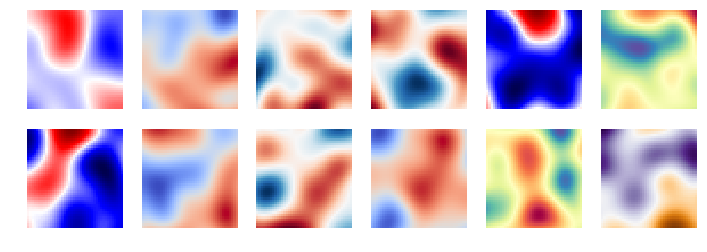

In [461]:
display_slices(X)

(2, 6)


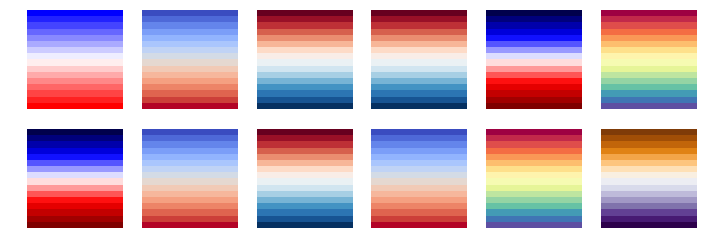

In [462]:
display_slices(y[:, :, None, :])

## Feature engineering

This is a sequence learning problem.

Want to constrain the output to only know about the colours in the training data.

Feels like we should be able to provide the training images and a code book, and ask only for the order of the colours in the image.

Options:

- Naive neighbours with shifts
- LSTM or spatial LSTM?
- Do a classification first, into discrete colours. Then give those colours to an ordering network.
- 'Lock' the colours together into a generated number or triple... but would have to span the full scale otheriw seit's no longer a regression problem. (I doubt this would work)

In [463]:
X.shape

(1000, 42, 42, 3)

In [467]:
Xo = X[:, :-1, :-1, :]
Xs = X[:, 1:, 1:, :]

In [468]:
assert Xo.shape == Xs.shape

In [472]:
X = np.hstack([Xo.reshape((n, -1, 3)), Xs.reshape((n, -1, 3))])

X.shape

(1000, 3362, 3)

In [487]:
nv = 20

data_val = gen_data(nv, kernel_size=(29,29))

X_val, y_val = make_X_and_y(data_val, cmap_group=group, steps=steps)

Xo = X_val[:, :-1, :-1, :]
Xs = X_val[:, 1:, 1:, :]

X_val = np.hstack([Xo.reshape((nv, -1, 3)), Xs.reshape((nv, -1, 3))])

## Training

### Deep neural net

In [488]:
n = X.shape[0]
assert n == y.shape[0]

X_train, y_train = X.reshape((n, -1)), y.reshape((n, -1))

In [489]:
X_val, y_val = X_val.reshape((nv, -1)), y_val.reshape((nv, -1))

In [490]:
from sklearn.neural_network import MLPRegressor

hidden = [
    6*steps,
    9*steps,
    9*steps,
    ]

nn = MLPRegressor(hidden_layer_sizes=hidden,
                  max_iter=10*n,
                  random_state=42,
                 )

In [491]:
nn.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[96, 144, 144], learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [492]:
nn.n_outputs_

48

In [493]:
X_train.shape, y_train.shape

((1000, 10086), (1000, 48))

In [494]:
X_val.shape, y_val.shape

((20, 10086), (20, 48))

In [495]:
y_pred = nn.predict(X_val)

(2, 6)


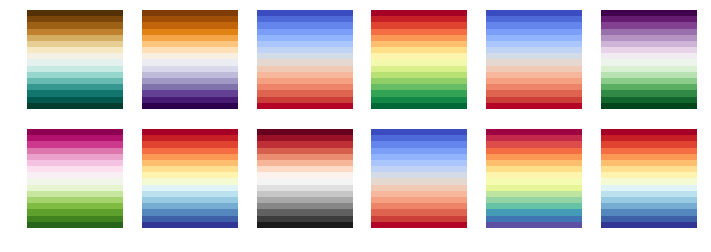

In [496]:
display_slices(y_val.reshape((nv, -1, 3))[:, :, None, :])

(2, 6)


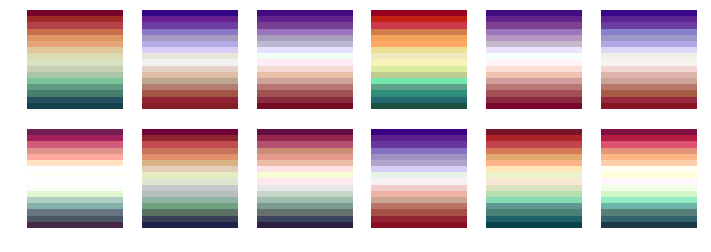

In [497]:
y_pred[y_pred < 0] = 0
y_pred[y_pred > 1] = 1
display_slices(y_pred.reshape((nv, -1, 3))[:, :, None, :])

In [ ]:
from sklearn.metrics import mean

### DNN in TensorFlow

In [ ]:
# # CONVOLTIONAL LAYER
# model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
# model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
# model.add(tf.keras.layers.Dropout(0.25))

In [516]:
import tensorflow as tf

model = tf.keras.models.Sequential()

# Input
model.add(tf.keras.layers.Dense(6*steps, input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.25))
# model.add(tf.keras.layers.Flatten())

# Layer 1
model.add(tf.keras.layers.Dense(9*steps))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.25))

# Layer 2
model.add(tf.keras.layers.Dense(9*steps))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.25))

# Layer 3
# model.add(tf.keras.layers.Dense(9*steps))
# model.add(tf.keras.layers.Activation('elu'))
# model.add(tf.keras.layers.Dropout(0.25))

# Output
model.add(tf.keras.layers.Dense(3*steps))
model.add(tf.keras.layers.Activation('tanh'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 96)                968352    
_________________________________________________________________
activation_17 (Activation)   (None, 96)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 144)               13968     
_________________________________________________________________
activation_18 (Activation)   (None, 144)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 144)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 144)               20880     
__________

In [517]:
model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.mean_squared_error,
    metrics=['mean_squared_error'],
)

def train_gen(X_train, y_train):
    while True:
        yield X_train, y_train

model.fit_generator(
    train_gen(X_train, y_train),
    epochs=1,
    steps_per_epoch=1000,
    validation_data=(X_val, y_val),
)

Epoch 1/1
1000/1000 [==============================] - 91s 91ms/step - loss: 0.0704 - mean_squared_error: 0.0704 - val_loss: 0.0200 - val_mean_squared_error: 0.0200


(2, 6)


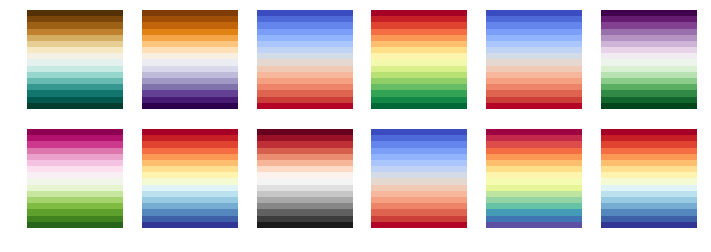

In [518]:
display_slices(y_val.reshape((nv, -1, 3))[:, :, None, :])

In [520]:
y_pred = model.predict(X_val)

(2, 6)


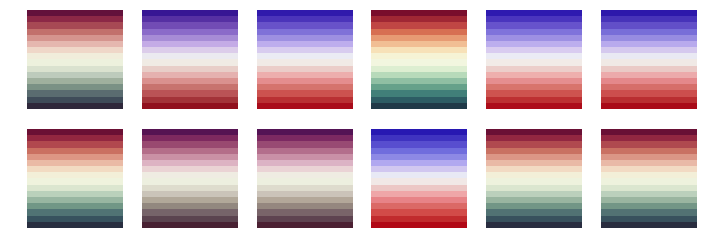

In [521]:
y_pred[y_pred < 0] = 0
y_pred[y_pred > 1] = 1
display_slices(y_pred.reshape((nv, -1, 3))[:, :, None, :])

In [ ]:

def plot_predictions(images, predictions, actuals):
    n = images.shape[0]
    nc = int(np.ceil(n / 4))
    f, axes = pyplot.subplots(nc, 4)
    for i in range(nc * 4):
        y = i // 4
        x = i % 4
        axes[x, y].axis('off')

        pred = LABEL_NAMES[np.argmax(predictions[i])]
        actual = LABEL_NAMES[actuals[i]]
        conf = np.max(predictions[i])
        if i > n:
            continue
        axes[x, y].imshow(images[i])
        axes[x, y].set_title("{} {:.3f}\n {}".format(pred, conf, actual))

    pyplot.gcf().set_size_inches(10, 12)  

plot_predictions(np.squeeze(X_val[:16]), 
                 model.predict(X_val[:16]),
                 np.squeeze(y_val[:16])
                )

### Random forest regressor

In [498]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200,
                           n_jobs=6,
                          )

rf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
y_pred = rf.predict(X_val)

In [ ]:
display_slices(y_val.reshape((nv, -1, 3))[:, :, None, :])

In [ ]:
y_pred[y_pred < 0] = 0
y_pred[y_pred > 1] = 1
display_slices(y_pred.reshape((nv, -1, 3))[:, :, None, :])